In [ ]:
import os
import cv2
import csv
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
import xml.etree.ElementTree as ET

# Créer le fichier CSV contenant les bounding box (TER Killian M1)

In [ ]:
def generate_bounding_boxes(mask_path):
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    bounding_boxes = []
    for contour in contours:
        x, y, w, h = cv2.boundingRect(contour)
        bounding_boxes.append([float(x), float(y), float(w), float(h)])

    return bounding_boxes

mask_folder = "data_test_yolov10/test/masks"

mask_files = os.listdir(mask_folder)

with open("data_test_yolov10/test/test.csv", "w", newline="") as csvfile:
    fieldnames = ['image_id', 'width', 'height', 'bbox', 'source']
    writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
    writer.writeheader()

    for mask_file in mask_files:
        mask_path = os.path.join(mask_folder, mask_file)
        bounding_boxes = generate_bounding_boxes(mask_path)

        # Obtenir les informations sur l'image
        img = cv2.imread(mask_path)
        height, width, _ = img.shape

        for box in bounding_boxes:
            writer.writerow({'image_id': mask_file.replace(".png", ".jpg"), 'width': width, 'height': height, 'bbox': box, 'source': 'diseas'})

In [32]:
train = pd.read_csv("../code/data_leaf_disease/data/test/test.csv")
print(train.head())

      image_id  width  height                        bbox  source
0  00000_1.jpg    235     326     [96.0, 281.0, 7.0, 8.0]  diseas
1  00000_1.jpg    235     326    [102.0, 267.0, 7.0, 9.0]  diseas
2  00000_1.jpg    235     326    [89.0, 255.0, 11.0, 9.0]  diseas
3  00000_1.jpg    235     326  [108.0, 246.0, 12.0, 14.0]  diseas
4  00000_1.jpg    235     326  [143.0, 245.0, 19.0, 24.0]  diseas


# Tester le fichier CSV

00000_1


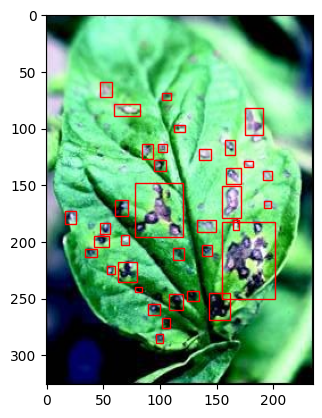

In [ ]:
train = pd.read_csv("data_leaf_disease/aug_data/test/test.csv")

first_image_id = os.path.splitext(train.loc[0, 'image_id'])[0]

images_data = train[train['image_id'].str.contains(first_image_id)]

first_image_path = os.path.join("data_leaf_disease/aug_data/test/images", first_image_id + ".jpg")

image = Image.open(first_image_path)
fig, ax = plt.subplots(1)
ax.imshow(image)

for index, row in images_data.iterrows():
    # print(row['bbox'])
    x_min, y_min, x_max, y_max = eval(row['bbox'])
    width = x_max
    height = y_max
    rect = patches.Rectangle((x_min, y_min), width, height, linewidth=1, edgecolor='r', facecolor='none')
    ax.add_patch(rect)

plt.show()

***
***
***
# Créer le fichier XML contenant les bounding box, au même format que la base VOC

In [ ]:
def generate_bounding_boxes(mask_path):
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    bounding_boxes = []
    for contour in contours:
        x, y, w, h = cv2.boundingRect(contour)
        bounding_boxes.append([x, y, x+w, y+h])

    return bounding_boxes

mask_folder = "data/test/masks"
output_folder = "data/test/Annotations"  # Folder to save XML files
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

mask_files = os.listdir(mask_folder)

for mask_file in mask_files:
    mask_path = os.path.join(mask_folder, mask_file)
    bounding_boxes = generate_bounding_boxes(mask_path)

    # Get image information
    img = cv2.imread(mask_path)
    height, width, _ = img.shape

    # Create XML structure
    annotation = ET.Element("annotation")

    folder = ET.SubElement(annotation, "folder")
    folder.text = "images"

    filename = ET.SubElement(annotation, "filename")
    filename.text = mask_file

    size = ET.SubElement(annotation, "size")
    width_elem = ET.SubElement(size, "width")
    width_elem.text = str(width)
    height_elem = ET.SubElement(size, "height")
    height_elem.text = str(height)
    depth = ET.SubElement(size, "depth")
    depth.text = "3"

    segmented = ET.SubElement(annotation, "segmented")
    segmented.text = "0"

    for box in bounding_boxes:
        obj = ET.SubElement(annotation, "object")

        name = ET.SubElement(obj, "name")
        name.text = "disease"

        pose = ET.SubElement(obj, "pose")
        pose.text = "Unspecified"

        truncated = ET.SubElement(obj, "truncated")
        truncated.text = "0"

        occluded = ET.SubElement(obj, "occluded")
        occluded.text = "0"

        difficult = ET.SubElement(obj, "difficult")
        difficult.text = "0"

        bbox = ET.SubElement(obj, "bndbox")
        xmin = ET.SubElement(bbox, "xmin")
        xmin.text = str(box[0])
        ymin = ET.SubElement(bbox, "ymin")
        ymin.text = str(box[1])
        xmax = ET.SubElement(bbox, "xmax")
        xmax.text = str(box[2])
        ymax = ET.SubElement(bbox, "ymax")
        ymax.text = str(box[3])

    # Write XML to file
    xml_file_path = os.path.join(output_folder, os.path.splitext(mask_file)[0] + ".xml")
    tree = ET.ElementTree(annotation)
    ET.indent(tree, space="\t", level=0)
    tree.write(xml_file_path, encoding="utf-8")

print("XML files saved in", output_folder)


XML files saved in data/test/annotation


# Tester BBOX avec XML

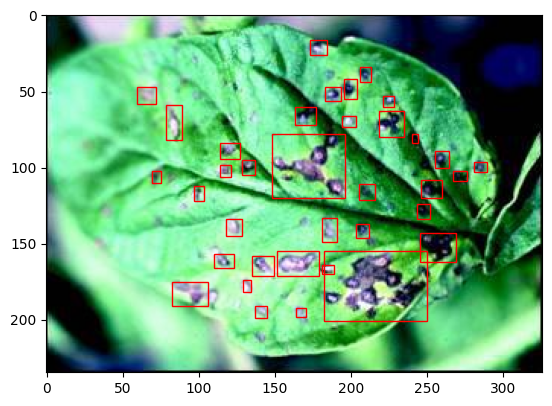

In [ ]:
# Function to parse XML file and extract bounding box coordinates
def parse_xml(xml_file):
    tree = ET.parse(xml_file)
    root = tree.getroot()
    boxes = []
    for obj in root.findall('object'):
        name = obj.find('name').text
        bbox = obj.find('bndbox')
        xmin = int(bbox.find('xmin').text)
        ymin = int(bbox.find('ymin').text)
        xmax = int(bbox.find('xmax').text)
        ymax = int(bbox.find('ymax').text)
        boxes.append((xmin, ymin, xmax, ymax))
    return boxes

# Directory where XML files are stored
xml_folder = "data/train/Annotations"

# Get a list of XML files
xml_files = [os.path.join(xml_folder, file) for file in os.listdir(xml_folder) if file.endswith('.xml')]

# Display images with bounding boxes
for xml_file in xml_files:
    # Parse XML file to extract bounding box coordinates
    bounding_boxes = parse_xml(xml_file)

    # Load image corresponding to XML file
    image_path = os.path.join("data/train/images", os.path.splitext(os.path.basename(xml_file))[0] + ".jpg")
    image = Image.open(image_path)

    # Plot image and bounding boxes
    plt.figure()
    plt.imshow(image)
    ax = plt.gca()
    for bbox in bounding_boxes:
        x_min, y_min, x_max, y_max = bbox
        width = x_max - x_min
        height = y_max - y_min
        rect = patches.Rectangle((x_min, y_min), width, height, linewidth=1, edgecolor='r', facecolor='none')
        ax.add_patch(rect)
    plt.show()
    break
